# CYPLAN 255 Project

## Using Open-Source Bike Share Trip Data to Inform Social Distancing Street Closures

### `4_Test_Code`

## 4.0 Initialize notebook

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import folium

## 4.1 Load data

In [3]:
# load bicycle facilities in Bay Area
facilities = gpd.read_file("../data/regional_bike_facilities.geojson")

# class / class_type :
# 1 = 'Off-Street Shared-Use Path'
# 2 = 'Bike Lane'
# 3 = 'On-Street Bike Route'

In [4]:
# load bounding boxes for station regions
bbox_gdf = gpd.read_file("../data/baywheels_regions_bbox.geojson")

In [5]:
# load census boundaries
outlines = gpd.read_file("zip://../data/cb_2016_us_state_500k.zip")
outlines = outlines.loc[outlines.GEOID=="06"]

In [6]:
# load processed trips data (with routes)
trips_gdf = gpd.read_file("../data/baywheels_routes_osmnx.geojson")

## 4.2 Testing - Unary_Union

Testing `geometry.unary_union` for trips one region at a time. The routes for San Francisco were not working in the other notebook so testing the code alone here without looping through each region.

In [7]:
trips_gdf.head()

,start_station_id,end_station_id,count,start_node,end_node,region,geometry
0,3.0,4.0,5,6489941287,65313138,San Francisco,"LINESTRING (-122.40508 37.78638, -122.40523 37..."
1,5.0,4.0,2,1723739163,65313138,San Francisco,"LINESTRING (-122.40807 37.78401, -122.40853 37..."
2,6.0,4.0,2,33241803,65313138,San Francisco,"LINESTRING (-122.40345 37.80504, -122.40228 37..."
3,10.0,4.0,1,65374771,65313138,San Francisco,"LINESTRING (-122.40497 37.79533, -122.40565 37..."
4,11.0,4.0,3,65328969,65313138,San Francisco,"LINESTRING (-122.39835 37.79709, -122.39819 37..."


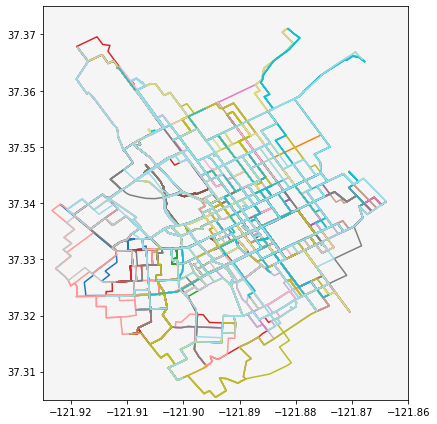

In [10]:
# Create figure
fig, ax = plt.subplots(figsize = (9,6))
ax.set_facecolor((1.0, 1.0, 1.0))

# Plot outline of CA
outlines.plot(ax=ax, color='whitesmoke')

# Plot routes
trips_gdf.loc[trips_gdf.region=="San Jose"].plot(ax=ax, cmap='tab20')

# Add plot descriptions, set bounds, and display 
bounds = bbox_gdf.loc[bbox_gdf.region=='San Jose'].geometry.bounds.reset_index()
ax.set_xlim((bounds.minx[0], bounds.maxx[0]))
ax.set_ylim((bounds.miny[0], bounds.maxy[0]))

plt.tight_layout()
plt.show()

In [11]:
# Create empty array to store route segments
lines_split = []

# Split route segments
for geom in trips_gdf.loc[trips_gdf.region=="San Jose"].geometry.unary_union:
    lines_split.append(geom)

In [13]:
split_gdf = gpd.GeoDataFrame(crs='epsg:4326', geometry=lines_split)

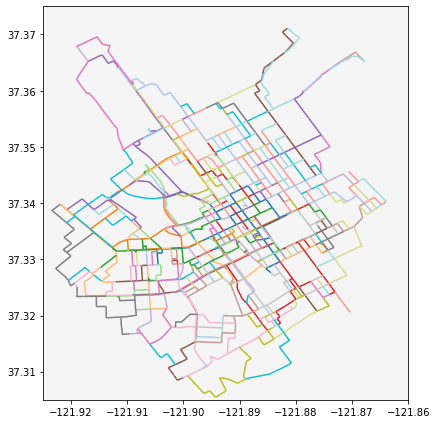

In [14]:
# Create figure
fig, ax = plt.subplots(figsize = (9,6))
ax.set_facecolor((1.0, 1.0, 1.0))

# Plot outline of CA
outlines.plot(ax=ax, color='whitesmoke')

# Plot routes
split_gdf.plot(ax=ax, cmap='tab20')

# Add plot descriptions, set bounds, and display 
bounds = bbox_gdf.loc[bbox_gdf.region=='San Jose'].geometry.bounds.reset_index()
ax.set_xlim((bounds.minx[0], bounds.maxx[0]))
ax.set_ylim((bounds.miny[0], bounds.maxy[0]))

plt.tight_layout()
plt.show()

In [15]:
# Add an id column to the segments that is different from the index.
# This id is one-indexed to differentiate it from the gpd index.
# This id will be needed after we intersect these segments with the trips LineStrings.
split_gdf['seg_id'] = range(1,len(split_gdf)+1)

In [16]:
# Spatial join of split_gdf and trips_gdf using the default operation 'intersects'
sjoin_gdf = gpd.tools.sjoin(split_gdf, trips_gdf)

In [17]:
# Spatial join with different method
sjoin_gdf = gpd.tools.sjoin(split_gdf, trips_gdf, op='within')

In [18]:
# Group geodataframe to get back to unique segments but now with counts
sjoin_group_gdf = sjoin_gdf.groupby('seg_id').agg({'count': 'count'})

# Reset index so not indexed on seg_id
sjoin_group_gdf.reset_index(inplace=True)

# Merge geometry with the grouped dataframe with counts per segment
sjoin_group_gdf = split_gdf.merge(sjoin_group_gdf, on='seg_id')

# Display grouped gdf
sjoin_group_gdf.head()

,geometry,seg_id,count
0,"LINESTRING (-121.90451 37.32904, -121.90468 37...",1,36
1,"LINESTRING (-121.90468 37.33109, -121.90375 37...",2,31
2,"LINESTRING (-121.90375 37.33114, -121.90384 37...",3,31
3,"LINESTRING (-121.90384 37.33182, -121.90219 37...",4,45
4,"LINESTRING (-121.90219 37.33187, -121.90125 37...",5,56


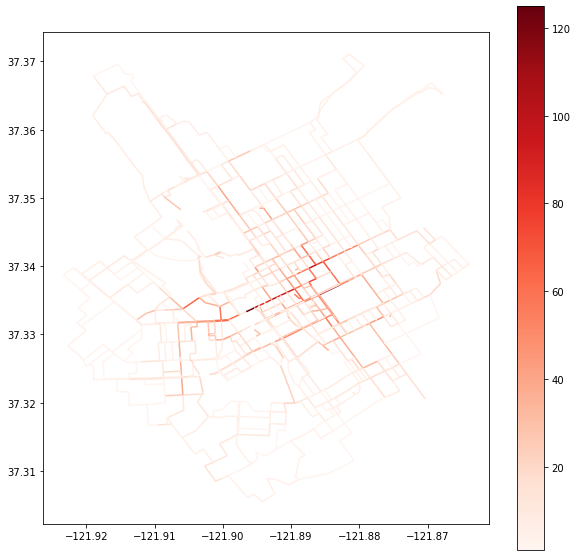

In [19]:
# Display geodataframe of route segments...now with counts!
fig, ax = plt.subplots(figsize=(10,10))

sjoin_group_gdf.plot(ax=ax, column='count', cmap='Reds', legend=True)

# bounds = bbox_gdf.loc[bbox_gdf.region=='East Bay'].geometry.bounds
# ax.set_xlim((bounds.minx[0], bounds.maxx[0]))
# ax.set_ylim((bounds.miny[0], bounds.maxy[0]))

plt.show()

In [20]:
sjoin_group_gdf.to_file(driver='GeoJSON', filename="../data/baywheels_freq_routes_sj.geojson")

## 4.3 Testing - Save OSM street network to .html file

Code from: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/11-plot-routes-folium-web-map.ipynb

The code below is currently just a test but may be used later to save the maps to .html files so they can be displayed on an external webpage.

In [ ]:
# import OSMnx methods
import osmnx as ox
import networkx as nx
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

In [ ]:
import folium
from IPython.display import IFrame

In [ ]:
# download the street network for Berkeley, CA
G0 = ox.graph_from_place('Berkeley, California, USA', network_type='bike', retain_all='False', simplify=True)

In [ ]:
# download the street network for Berkeley, CA
G1 = ox.graph_from_place('Oakland, California, USA', network_type='bike', retain_all='False', simplify=True)

In [ ]:
G = nx.compose(G0,G1)
del G0, G1

In [ ]:
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)

In [ ]:
# help(folium.Icon)

In [ ]:
# save as html file then display map as an iframe
# filepath = '../data/graph.html'
# graph_map.save(filepath)
# IFrame(filepath, width=600, height=500)

In [ ]:
# use networkx to calculate the shortest path between two nodes
origin_point = (37.868719, -122.259174)
origin_node = ox.get_nearest_node(G, origin_point)
# origin_node = list(G.nodes())[0]

destination_point = (37.851623, -122.252217)
destination_node = ox.get_nearest_node(G, destination_point)
# destination_node = list(G.nodes())[-1]

route_OD = nx.shortest_path(G, origin_node, destination_node, weight="length")
route_DO = nx.shortest_path(G, destination_node, origin_node, weight="length")

In [ ]:
# print(origin_point, destination_point)
# print(origin_node, destination_node)
# print(route)

In [ ]:
# plot the route with folium
# route_map = ox.plot_route_folium(G, route)

# plot the OD route with folium on top of the previously created route_graph_map
route_graph_map = ox.plot_route_folium(G, route_OD, 
                                       route_map=graph_map, 
                                       route_color='darkgreen',
                                       popup_attribute='length')

In [ ]:
# plot the OD route with folium on top of the previously created graph_map
route_graph_map = ox.plot_route_folium(G, route_DO, 
                                       route_map=route_graph_map, 
                                       route_color='darkblue',
                                       popup_attribute='length')

In [ ]:
# Add origin and destination stations to map
folium.Marker(
    [37.868719, -122.259174],
    icon=folium.Icon(color='green')
).add_to(route_graph_map)
folium.Marker(
    [37.851623, -122.252217],
    icon=folium.Icon(color='blue')
).add_to(route_graph_map)

In [ ]:
# save as html file then display map as an iframe
filepath = '../data/route_graph.html'
route_graph_map.save(filepath)
# IFrame(filepath, width=600, height=500)